https://www.kaggle.com/c/choose-tutors/ Ваша задача этом соревновании - предсказать вероятность того, подойдет ли репетитор для подготовки к экзамену по математике. Вам будут даны два датасета: train.csv (содержит признаки и целевую переменную) и test.csv (только признаки).

Сложность построения предсказания в том, что для тренировки дана выборка с распределением данных:

0    8891

1    1109

А предсказания ожидаются 5000 на 5000 по данным примерно того же диапазона.

У меня наивысший показатель - 0.69687 - дала логистическая регрессия с минимальным порогом отнесения данных к классу 1 и удалением столбцов, слабо коррелирующих с целевой переменной.

In [1]:
# You can only use these imports:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
submission_example = pd.read_csv('C:\\Users\\olhae\\Documents\\Geekbrains\\MatAlgs\\choose_tutors\\submission_example.csv')
test_data = pd.read_csv('C:\\Users\\olhae\\Documents\\Geekbrains\\MatAlgs\\choose_tutors\\test.csv')
train_data = pd.read_csv('C:\\Users\\olhae\\Documents\\Geekbrains\\MatAlgs\\choose_tutors\\train.csv')

In [3]:
train_data.describe()
# все данные в разумных пределах, на выросы не похоже

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.800900,1.974800,1702.440000,1.724300,0.37060,0.121500,0.117200,0.059100,0.02770,0.018000,64.435200,0.110900
std,2886.89568,8.030274,1.766883,523.789062,0.798845,0.48299,0.326724,0.321675,0.235824,0.16412,0.132958,13.595024,0.314024
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,33.000000,0.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,55.000000,0.000000
50%,4999.50000,46.000000,2.000000,1550.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,63.000000,0.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,74.000000,0.000000
max,9999.00000,68.000000,9.000000,3950.000000,4.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,100.000000,1.000000


In [4]:
test_data.describe()
# все данные так же в разумных пределах, диапазон очень похож на тренировочные данные

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,14999.50000,45.924500,1.985700,1699.910000,1.702300,0.372100,0.128100,0.115800,0.049000,0.029200,0.015100,64.149400
std,2886.89568,8.031977,1.771217,526.260094,0.789644,0.483389,0.334218,0.320001,0.215879,0.168375,0.121957,13.570096
min,10000.00000,23.000000,0.000000,300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,12499.75000,41.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000
50%,14999.50000,46.000000,2.000000,1550.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,17499.25000,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
max,19999.00000,68.000000,9.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,98.000000


In [5]:
train_data['choose'].value_counts()
# выборка не сбалансирована

0    8891
1    1109
Name: choose, dtype: int64

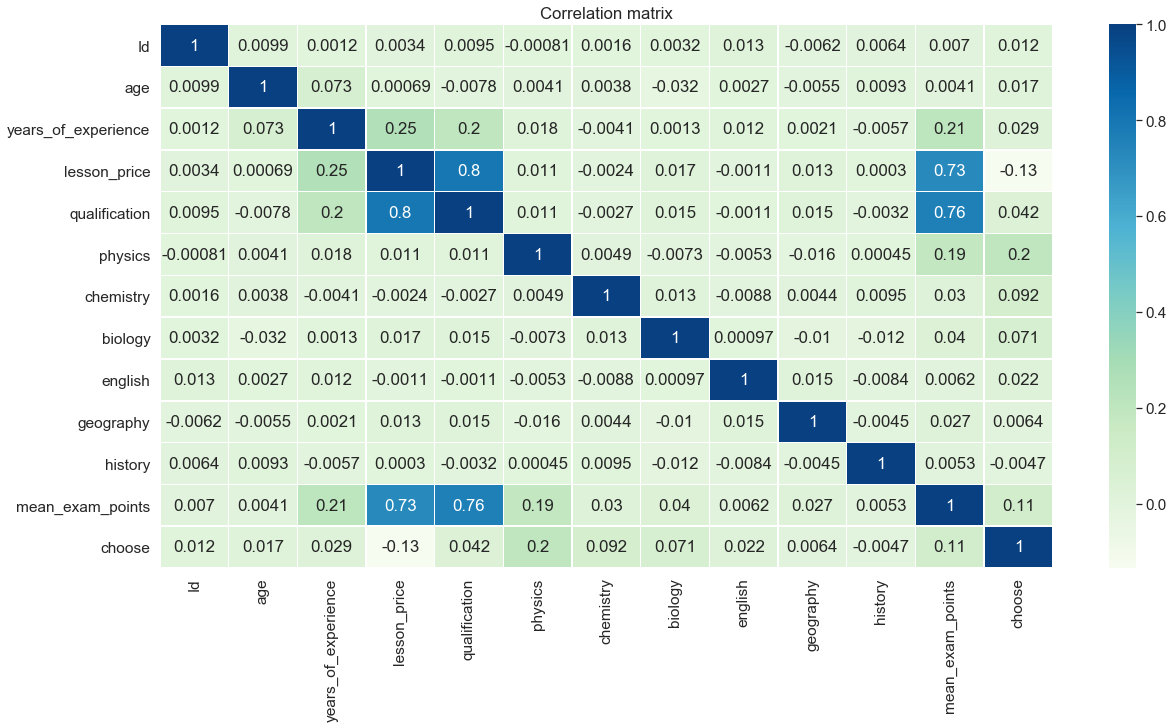

In [6]:
plt.figure(figsize = (20,10))

sns.set(font_scale=1.4)
sns.heatmap(train_data.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

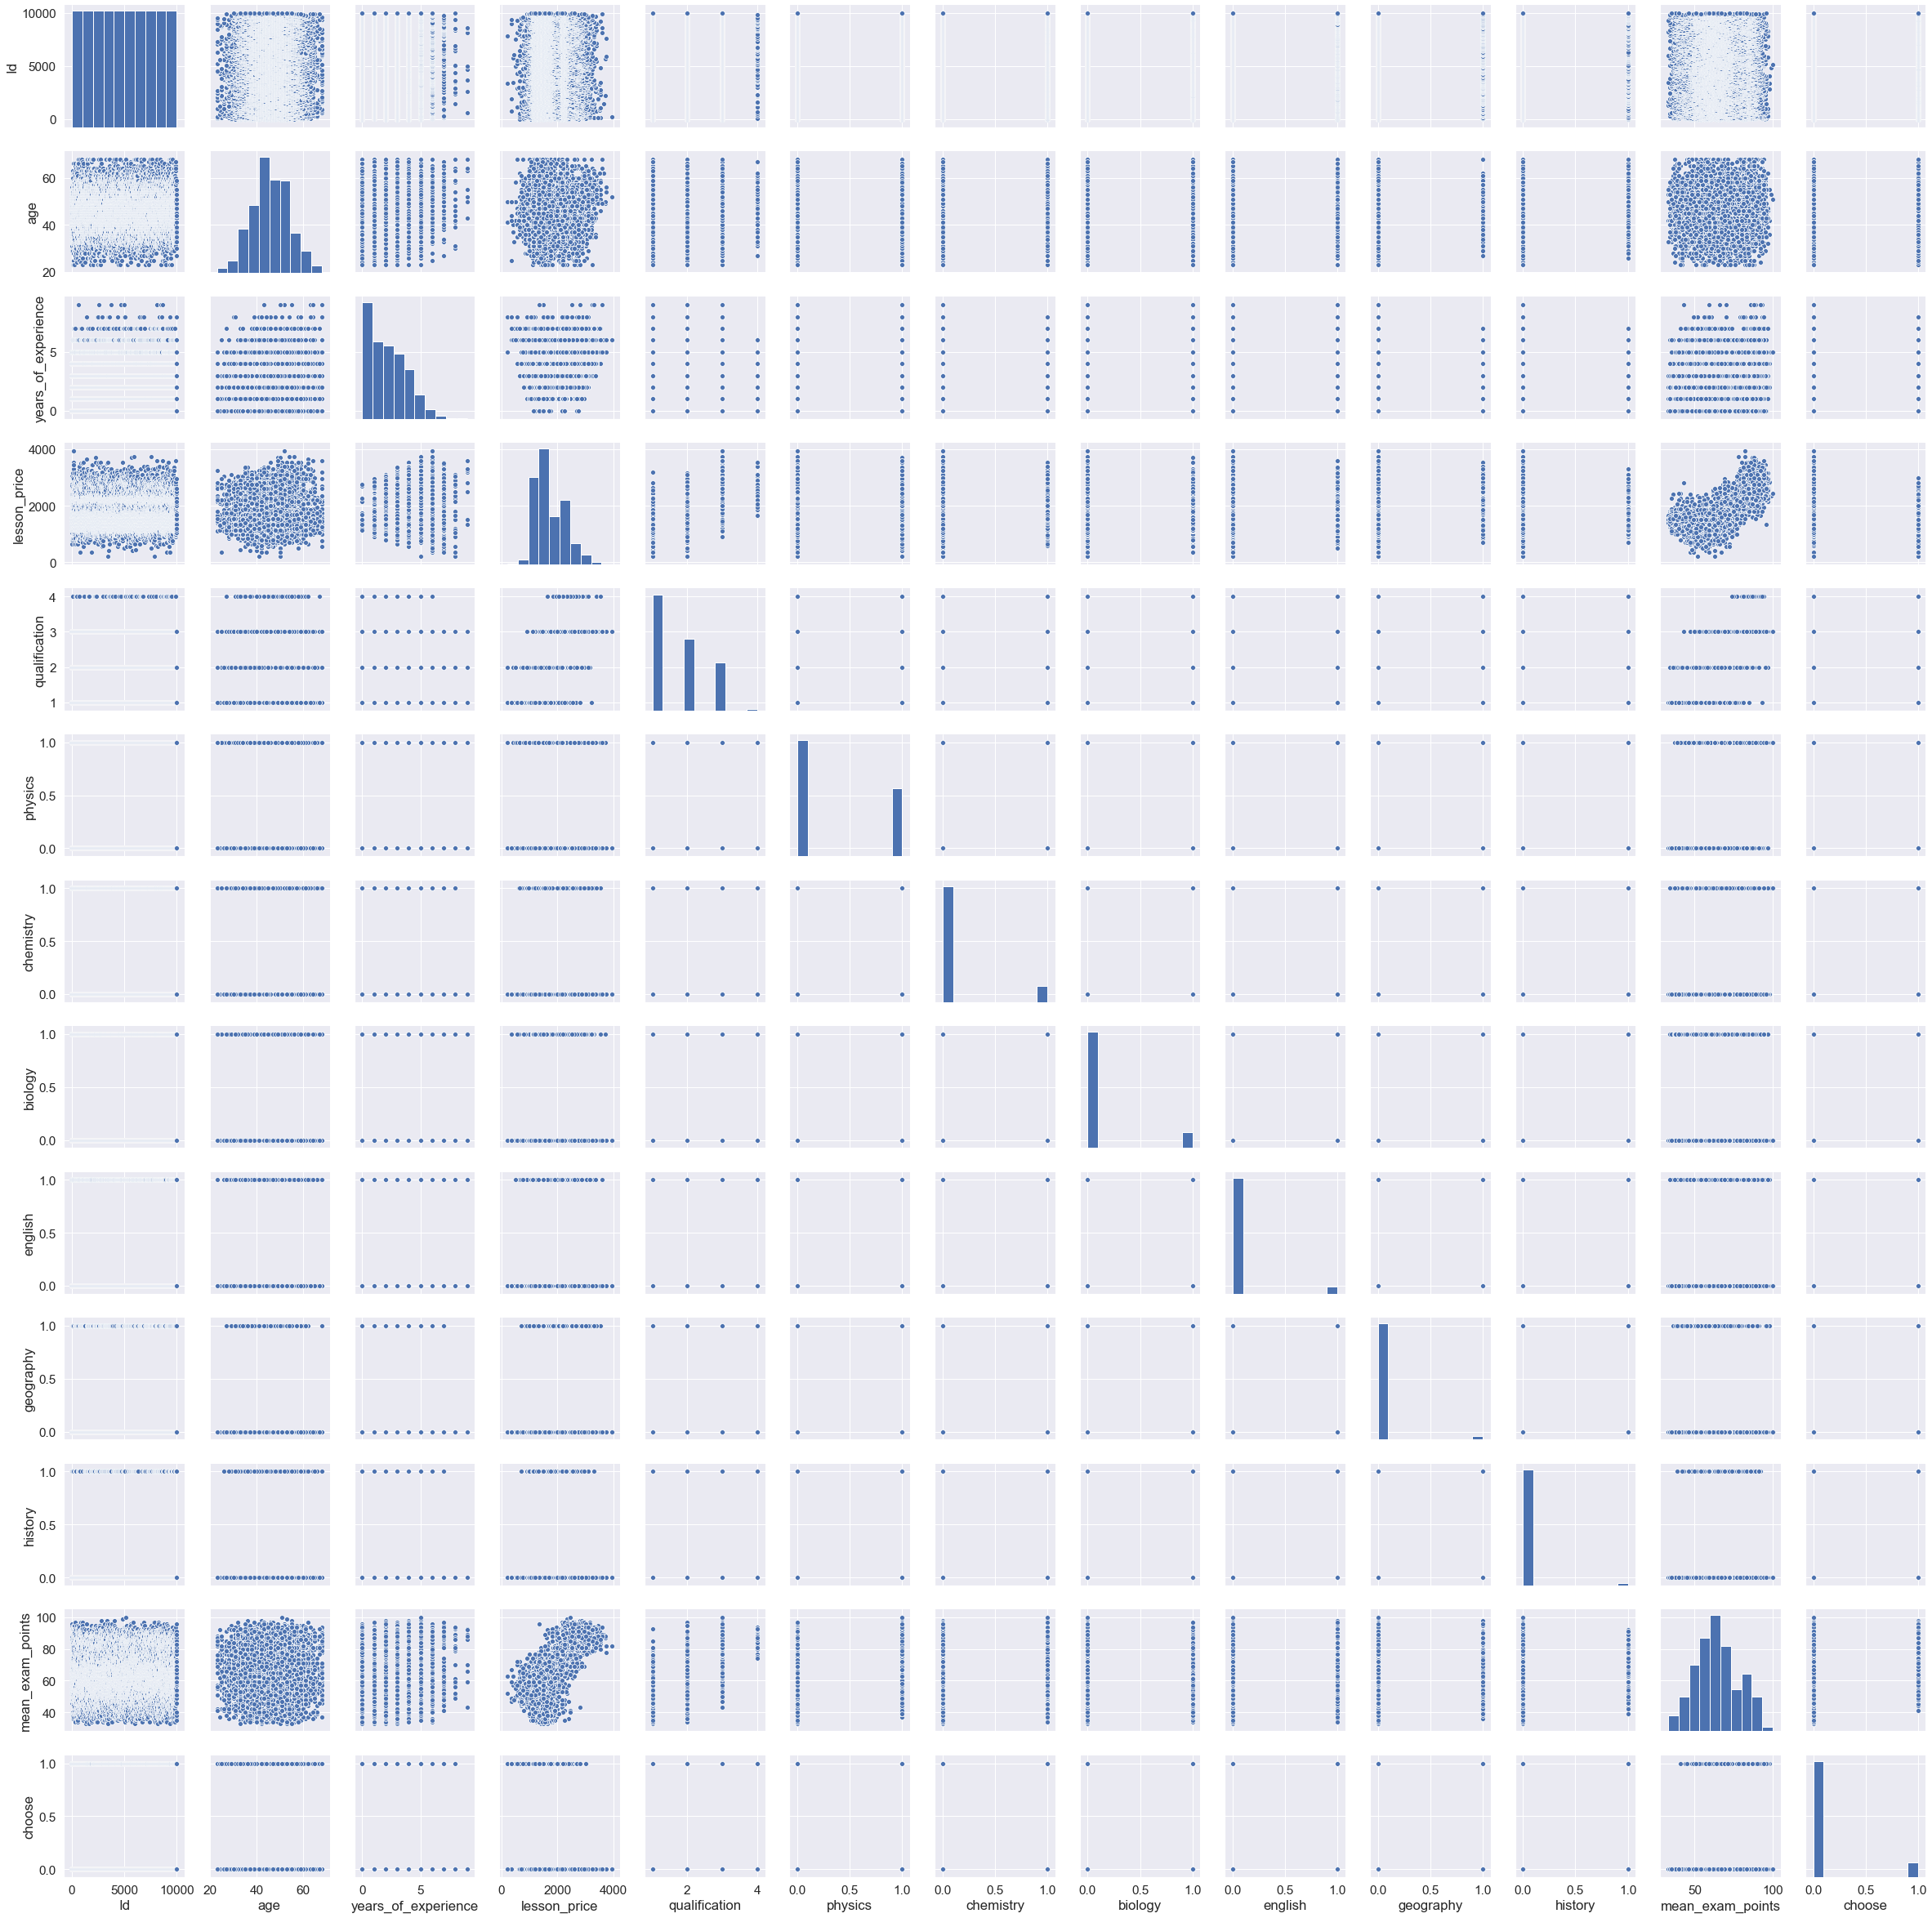

In [7]:
sns.pairplot(train_data)

In [8]:
columns = train_data.columns[:-1]
X = train_data[columns]
y = train_data['choose']

In [9]:
# определим функцию подготовки данных:
def df_prepare(df_preparing):
    df = df_preparing.copy()
    # удалим порядковый номер
    df.drop('Id', axis=1, inplace=True)
    # удалим данные с минимальной корреляцией:
    df.drop('age', axis=1, inplace=True)
    df.drop('chemistry', axis=1, inplace=True)
    df.drop('biology', axis=1, inplace=True)
    df.drop('geography', axis=1, inplace=True)
    df.drop('history', axis=1, inplace=True)
    # удалим сильно коррелирующий столбец:
    df.drop('qualification', axis=1, inplace=True)
    # переведем данные в вид массива numpy:
    df_arr = np.array(df)
    # нормализация данных:
    df_arr_norm = df_arr.copy()
    for i in range(len(df_arr)):
        df_arr_norm[i] = (df_arr[i] - df_arr[i].min()) / (df_arr[i].max() - df_arr[i].min())
    return df_arr_norm

In [10]:
X_ = df_prepare(X)
test_data_ = df_prepare(test_data)
y_arr = np.array(y)

In [11]:
# логистическая регрессия:
def log_loss(w, X, y):
    m = X.shape[1]

    # используем функцию сигмоиды, написанную ранее
    A = sigmoid(np.dot(w.T, X))
    
    loss = -1.0 / m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
    loss = np.squeeze(loss)
    grad = 1.0 / m * np.dot(X, (A - y).T)
    
    return loss, grad

def optimize(w, X, y, n_iterations, eta):
#     потери будем записывать в список для отображения в виде графика
    losses = []

    for i in range(n_iterations):        
        loss, grad = log_loss(w, X, y)
        w = w - eta * grad

        losses.append(loss)
        
    return w, losses

def predict(w, X):
    
    m = X.shape[1]
    
    y_predicted = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X))
    
#     За порог отнесения к тому или иному классу примем вероятность 0.1005
    for i in range(A.shape[1]):
        if (A[:,i] > 0.1005): 
            y_predicted[:, i] = 1
        elif (A[:,i] <= 0.1005):
            y_predicted[:, i] = 0
    
    return y_predicted

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [12]:
# поскольку тренировочная выборка несбалансированная, а методом проб установлено, что предсказание ожидается сбалансированное, 
# делить данные не имеет смысла, обучим модель на более полных данных - всей тестовой выборке.
X_tr = X_.transpose()
y_tr = y_arr.transpose()

# иницилизируем начальный вектор весов
w0 = np.zeros((X_tr.shape[0], 1))

n_iterations = 550000
eta = 0.1

w, losses = optimize(w0, X_tr, y_tr, n_iterations, eta)

y_predicted_train = predict(w, X_tr)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = np.mean([y_predicted_train == y_tr])*100

print(f"Итоговый вектор весов w: {w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")

Итоговый вектор весов w: [[ 1.96048627e+00]
 [-3.75903337e+00]
 [ 1.15603810e+00]
 [ 3.57504261e-02]
 [ 4.05973087e+01]]
Точность на обучающей выборке: 57.140


In [13]:
test_data_tr = test_data_.transpose()
y_pred_logr = predict(w, test_data_tr)

In [14]:
ids = np.arange(10000, 20000, 1)
preds_logr = pd.DataFrame({'Id': ids, 'choose': y_pred_logr[0]})
preds_logr['choose'].value_counts()

0.0    5030
1.0    4970
Name: choose, dtype: int64

In [ ]:
preds_logr.to_csv('OBerezovskaya_predictions_choose_tutors.csv', index=None)